In [2]:
import torch  
import numpy as np
import wandb
import platform
import sys
from datasets import load_dataset
import wandb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, fbeta_score
from transformers import EarlyStoppingCallback
from transformers import ViTForImageClassification, AutoImageProcessor
from transformers import TrainingArguments, Trainer
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt 
import cv2
from einops import rearrange
import albumentations as A
from functools import partial
from tqdm.notebook import tqdm
from torchvision.transforms import v2


/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <3EF8D74C-9F11-3C9E-85DB-9E76BCCBE7A0> /Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning

In [3]:
num_classes = 3
seed = 1234
dataset_path = "pawlo2013/chest_xray"
image_size = 224

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch, 'has_mps', False)
device = "mps" if getattr(torch, 'has_mps', False) \
    else "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if getattr(
    torch, 'has_mps', False) else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Python {sys.version}")

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")



Python Platform: macOS-14.4.1-arm64-arm-64bit
PyTorch Version: 2.3.0
Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE


/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_6617/409009546.py:7: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  has_mps = getattr(torch, 'has_mps', False)
/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_6617/409009546.py:8: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \
/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_6617/409009546.py:10: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(


In [4]:
train_dataset = load_dataset(dataset_path, split='train')

class_names = train_dataset.features['label'].names


#delete train_dataset from memory
del train_dataset




def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    
    
    # Overall accuracy
    acc = accuracy_score(labels, preds)
    
    # Precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0) 
    
    # Confusion matrix to calculate per-class accuracy
    cm = confusion_matrix(labels, preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    
    # Prepare the per-class accuracy in a dictionary
    per_class_accuracy = {f"accuracy_class_{class_names[i]}": acc for i, acc in enumerate(per_class_acc)}
    
    # Combine all metrics into one dictionary
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    metrics.update(per_class_accuracy)

    # log the confusion matrix to W&B

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                             y_true=labels,
                                                          preds=preds,
                                                           class_names=class_names)})    

    
    return metrics
   

def calculate_class_weights(dataset_path, device):
    # Load the dataset
    dataset = load_dataset(dataset_path)
    
    # Assuming the label column is named 'label'
    train_labels = dataset['train']['label']
    
    # Count the number of samples in each class
    label_counts = Counter(train_labels)
    
    # Get total number of samples
    total_samples = len(train_labels)
    
    # Calculate class weights: inverse of class frequency
    class_weights = {label: total_samples / count for label, count in label_counts.items()}
    
    # Convert class weights to tensor and move to the specified device
    class_weights_tensor = torch.tensor(
        [class_weights[label] for label in range(len(class_weights))],
        dtype=torch.float
    ).to(device)
    
    return class_weights_tensor

class_weights = calculate_class_weights(dataset_path, device)


In [6]:

model_name_or_path = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_name_or_path)


train_transforms = v2.Compose([

    v2.RandomRotation(degrees=(-10, 10)),  # Very slight rotation
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),

])



def train_transform(example_batch, processor):
    inputs = processor([train_transforms(x.convert("RGB")) for x in example_batch['image']], return_tensors='pt')
    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

def validation_and_test_transform(example_batch, processor):
    inputs = processor([(x.convert("RGB")) for x in example_batch['image']], return_tensors='pt')
    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }




train_tranform = partial(train_transform, processor=processor)
validation_and_train_tranform = partial(validation_and_test_transform, processor=processor)


train_dataset = load_dataset(dataset_path, split='train')
validation_dataset = load_dataset(dataset_path, split='validation')
test_dataset = load_dataset(dataset_path, split='test')
prepared_dataset_train_vision_transformer = train_dataset.with_transform(train_tranform)
prepared_dataset_validation_vision_transformer = validation_dataset.with_transform(validation_and_train_tranform)
prepared_dataset_test_vision_transformer = test_dataset.with_transform(validation_and_train_tranform)



labels = class_names




def frozen_model_init():

    model_name_or_path = "google/vit-base-patch16-224-in21k"

    not_frozen_layers = ["encoder.layer.11", "vit.layernorm.weight", "vit.layernorm.bias", "classifier.weight", "classifier.bias"]

    frozen_model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    )

    # Freeze all layers except the last one
    for name, param in frozen_model.named_parameters():
        if all(not_frozen_layer not in name for not_frozen_layer in not_frozen_layers):
            param.requires_grad = False
    
    return frozen_model




/Users/pawelpiwowarski/miniforge3/envs/tf/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.embeddings.cls_token                                                         False
vit.embeddings.position_embeddings                                               False
vit.embeddings.patch_embeddings.projection.weight                                False
vit.embeddings.patch_embeddings.projection.bias                                  False
vit.encoder.layer.0.attention.attention.query.weight                             False
vit.encoder.layer.0.attention.attention.query.bias                               False
vit.encoder.layer.0.attention.attention.key.weight                               False
vit.encoder.layer.0.attention.attention.key.bias                                 False
vit.encoder.layer.0.attention.attention.value.weight                             False
vit.encoder.layer.0.attention.attention.value.bias                               False
vit.encoder.layer.0.attention.output.dense.weight                                False
vit.encoder.layer.0.attention.output.dense.

In [5]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

<h2> Train of frozen model with data augmentation </h2>

In [ ]:

wandb.init(project="vit-pneumonia-x-ray_data_augmentation", 
               name=f"vit-pneumonia-x-ray-run_5", config={
                   "model_name": model_name_or_path,
                   "batch_size": 32,
                   "num_classes": num_classes,
                   "seed": seed,
                   "dataset_path": dataset_path,
               })


training_args = TrainingArguments(
      output_dir="./vit-pneumonia-x-ray_data_augmentation_frozen_model",
      per_device_train_batch_size=32,
      per_device_eval_batch_size=32,
      evaluation_strategy="steps",
      num_train_epochs=50,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      learning_rate=1e-3,
      save_total_limit=1,
      remove_unused_columns=False,
      metric_for_best_model="eval_loss",
      push_to_hub=False,
      report_to='wandb',
      load_best_model_at_end=True,
    )

trainer = CustomTrainer(
        model_init=frozen_model_init,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_dataset_train_vision_transformer,
        eval_dataset=prepared_dataset_validation_vision_transformer,
        tokenizer=processor,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
    )

trainer.train()

trainer.evaluate(prepared_dataset_test_vision_transformer, metric_key_prefix="test")


<h2> Compare Data Augmentation vs No Data Augmentation </h2>

In [80]:
import wandb
from collections import defaultdict
import pandas as pd

# Initialize the API
api = wandb.Api()


# Dictionary to store the results
def get_stats(wandb_project_name):
    results = defaultdict(list) 
    project_runs = api.runs(wandb_project_name)

    print(f"Number of runs in project {wandb_project_name}: {len(project_runs)}")

    for run in project_runs:
        test_accuracy = run.summary.get("test/accuracy")
        test_precision = run.summary.get("test/precision")
        test_recall = run.summary.get("test/recall")
        test_f1 = run.summary.get("test/f1")
        bacterial_accuracy = run.summary.get("test/accuracy_class_Bacterial")
        viral_accuracy = run.summary.get("test/accuracy_class_Viral")
        normal_accuracy = run.summary.get("test/accuracy_class_Normal")

        results["test_accuracy"].append(test_accuracy)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        results["bacterial_accuracy"].append(bacterial_accuracy)
        results["viral_accuracy"].append(viral_accuracy)
        results["normal_accuracy"].append(normal_accuracy)

    return results

def make_table_with_mean_and_sd(results_dict):
    results_df = pd.DataFrame(results_dict)
    
    # Calculate the mean and standard deviation
    mean_values = results_df.mean()
    std_values = results_df.std()
    
    # Combine the results into one DataFrame with the format "mean ± standard deviation"
    formatted_results = mean_values.astype(str) + " ± " + std_values.astype(str)
    formatted_results_df = pd.DataFrame(formatted_results, columns=["mean ± standard_deviation"])
    
    return formatted_results_df

results_1 = get_stats("vit-pneumonia-x-ray_data_augmentation")
results_2 = get_stats("vit-pneumonia-x-ray_no_data_augmentation_frozen_except_last")
table = make_table_with_mean_and_sd(results_1)



# show best result from results_1


best_result = max(results_1["test_accuracy"])
best_result_index = results_1["test_accuracy"].index(best_result)

print(f"Best test accuracy: {best_result}")
print(f"Best test precision: {results_1['test_precision'][best_result_index]}")
print(f"Best test recall: {results_1['test_recall'][best_result_index]}")
print(f"Best test f1: {results_1['test_f1'][best_result_index]}")
print(f"Best bacterial accuracy: {results_1['bacterial_accuracy'][best_result_index]}")
print(f"Best viral accuracy: {results_1['viral_accuracy'][best_result_index]}")
print(f"Best normal accuracy: {results_1['normal_accuracy'][best_result_index]}")





Number of runs in project vit-pneumonia-x-ray_data_augmentation: 5
Number of runs in project vit-pneumonia-x-ray_no_data_augmentation_frozen_except_last: 5
Best test accuracy: 0.8686006825938567
Best test precision: 0.8777209079935063
Best test recall: 0.8686006825938567
Best test f1: 0.8696769616590414
Best bacterial accuracy: 0.9541284403669724
Best viral accuracy: 0.8208955223880597
Best normal accuracy: 0.8162393162393162


In [89]:
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, levene, f_oneway

def convert_to_dataframe(data):
    """
    Convert a defaultdict to a pandas DataFrame.
    
    Parameters:
    data (defaultdict): Dictionary containing lists of statistics.
    
    Returns:
    df (pd.DataFrame): DataFrame with the same data.
    """
    return pd.DataFrame(data)

def check_homogeneity_of_variance(df1, df2):
    """
    Check homogeneity of variance between two dataframes using Levene's test.
    
    Parameters:
    df1 (pd.DataFrame): DataFrame containing statistics of the first run.
    df2 (pd.DataFrame): DataFrame containing statistics of the second run.
    
    Returns:
    levene_results (pd.DataFrame): DataFrame with Levene's test statistics and p-values for each metric.
    """
    if not df1.columns.equals(df2.columns):
        raise ValueError("Both dataframes must have the same columns")

    metrics = df1.columns
    levene_results = pd.DataFrame(columns=["Levene Statistic", "P-value", "Equal Variance"], index=metrics)
    
    for metric in metrics:
        stat, p_value = levene(df1[metric], df2[metric])
        equal_variance = p_value > 0.05
        levene_results.loc[metric] = [stat, p_value, equal_variance]
    
    return levene_results
def compare_model_statistics(df1, df2, alpha=0.05, use_paired_t_test=True):
    """
    Compare model statistics between two dataframes using paired t-test or Wilcoxon signed-rank test.
    
    Parameters:
    df1 (pd.DataFrame): DataFrame containing statistics of the first run.
    df2 (pd.DataFrame): DataFrame containing statistics of the second run.
    alpha (float): Significance level for the hypothesis test.
    use_paired_t_test (bool): Whether to use paired t-test (True) or Wilcoxon signed-rank test (False).
    
    Returns:
    results (pd.DataFrame): DataFrame with the test statistics and p-values for each metric.

    """

    if isinstance(df1, defaultdict):
        df1 = convert_to_dataframe(df1)


    if isinstance(df2, defaultdict):
        df2 = convert_to_dataframe(df2)

    if not df1.columns.equals(df2.columns):
        raise ValueError("Both dataframes must have the same columns")

    metrics = df1.columns
    results = pd.DataFrame(columns=["Mean ViT DA", "Mean ViT No DA", "P-value", "Reject Null Hypothesis (alternative Mean 1 > Mean 2)"], index=metrics)
    
    for metric in metrics:
        data1_metric = df1[metric]
        data2_metric = df2[metric]
        
        mean1 = data1_metric.mean()
        mean2 = data2_metric.mean()
        
        if use_paired_t_test:
            _, p_value = ttest_rel(data1_metric, data2_metric, alternative="greater")
        else:
            _, p_value = f_oneway(data1_metric, data2_metric)
        
        reject_null = p_value < alpha
        results.loc[metric] = [mean1, mean2, p_value, reject_null]
    
    return results





print(compare_model_statistics(results_1, results_2, alpha=0.05, use_paired_t_test=False))

                   Mean ViT DA Mean ViT No DA   P-value  \
test_accuracy         0.843003       0.745392  0.000021   
test_precision        0.855092       0.808541  0.000094   
test_recall           0.843003       0.745392  0.000021   
test_f1               0.843905       0.745605   0.00002   
bacterial_accuracy    0.948624       0.934862  0.115077   
viral_accuracy        0.792537       0.783582  0.603962   
normal_accuracy       0.773504       0.547009  0.000007   

                   Reject Null Hypothesis (alternative Mean 1 > Mean 2)  
test_accuracy                                                    True    
test_precision                                                   True    
test_recall                                                      True    
test_f1                                                          True    
bacterial_accuracy                                              False    
viral_accuracy                                                  False    
normal_ac

<h2> Sanity Check Random Initilize the weights ViT </h2>

In [ ]:
from transformers import ViTConfig

def random_init_model(trial):


    config = ViTConfig(
        num_labels=num_classes,

    )
    
    model = ViTForImageClassification(config)
   



    return model


wandb.init(project="vit-pneumonia-x-ray_data_augmentation_from_scratch")

training_args = TrainingArguments(
        output_dir="./vit-pneumonia-x-ray_data_augmentation_from_scratch",
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        evaluation_strategy="steps",
        num_train_epochs=50,
        save_steps=100,
        eval_steps=100,
        logging_steps=10,
        learning_rate=1e-4,
        save_total_limit=1,
        remove_unused_columns=False,
        metric_for_best_model="eval_loss",
        push_to_hub=False,
        report_to='wandb',
        load_best_model_at_end=True,
        )


trainer = Trainer(
        model_init=random_init_model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=prepared_dataset_train_vision_transformer,
        eval_dataset=prepared_dataset_validation_vision_transformer,
        tokenizer=processor,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
    )

trainer.train()

trainer.evaluate(prepared_dataset_test_vision_transformer, metric_key_prefix="test")




<h2> Push the best model to the hub </h2>

In [5]:
best_model_path = './vit_86_acc'

best_model = ViTForImageClassification.from_pretrained(best_model_path, num_labels=num_classes, 
                                                       id2label = {str(i): label for i, label in enumerate(class_names)},
                                                         label2id = {label: i for i, label in enumerate(class_names)                    })

In [ ]:

                                                
                                   

train_args =    TrainingArguments(
    output_dir='./vit-pneumonia-x-ray_3_class',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    num_train_epochs=50,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=1,
    remove_unused_columns=False,
    metric_for_best_model="eval_loss",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
)


trainer = Trainer(
    model=best_model,
    args=train_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset_train_vision_transformer,
    eval_dataset=prepared_dataset_validation_vision_transformer,
    tokenizer=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

trainer.push_to_hub("pawlo2013/vit-pneumonia-x-ray_3_class")

<h2> Plot Attention HeatMap </h2>

Samples found for all classes!


/var/folders/cm/2c5qsgtd2z9_c__1cmj825dm0000gn/T/ipykernel_2363/68190972.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


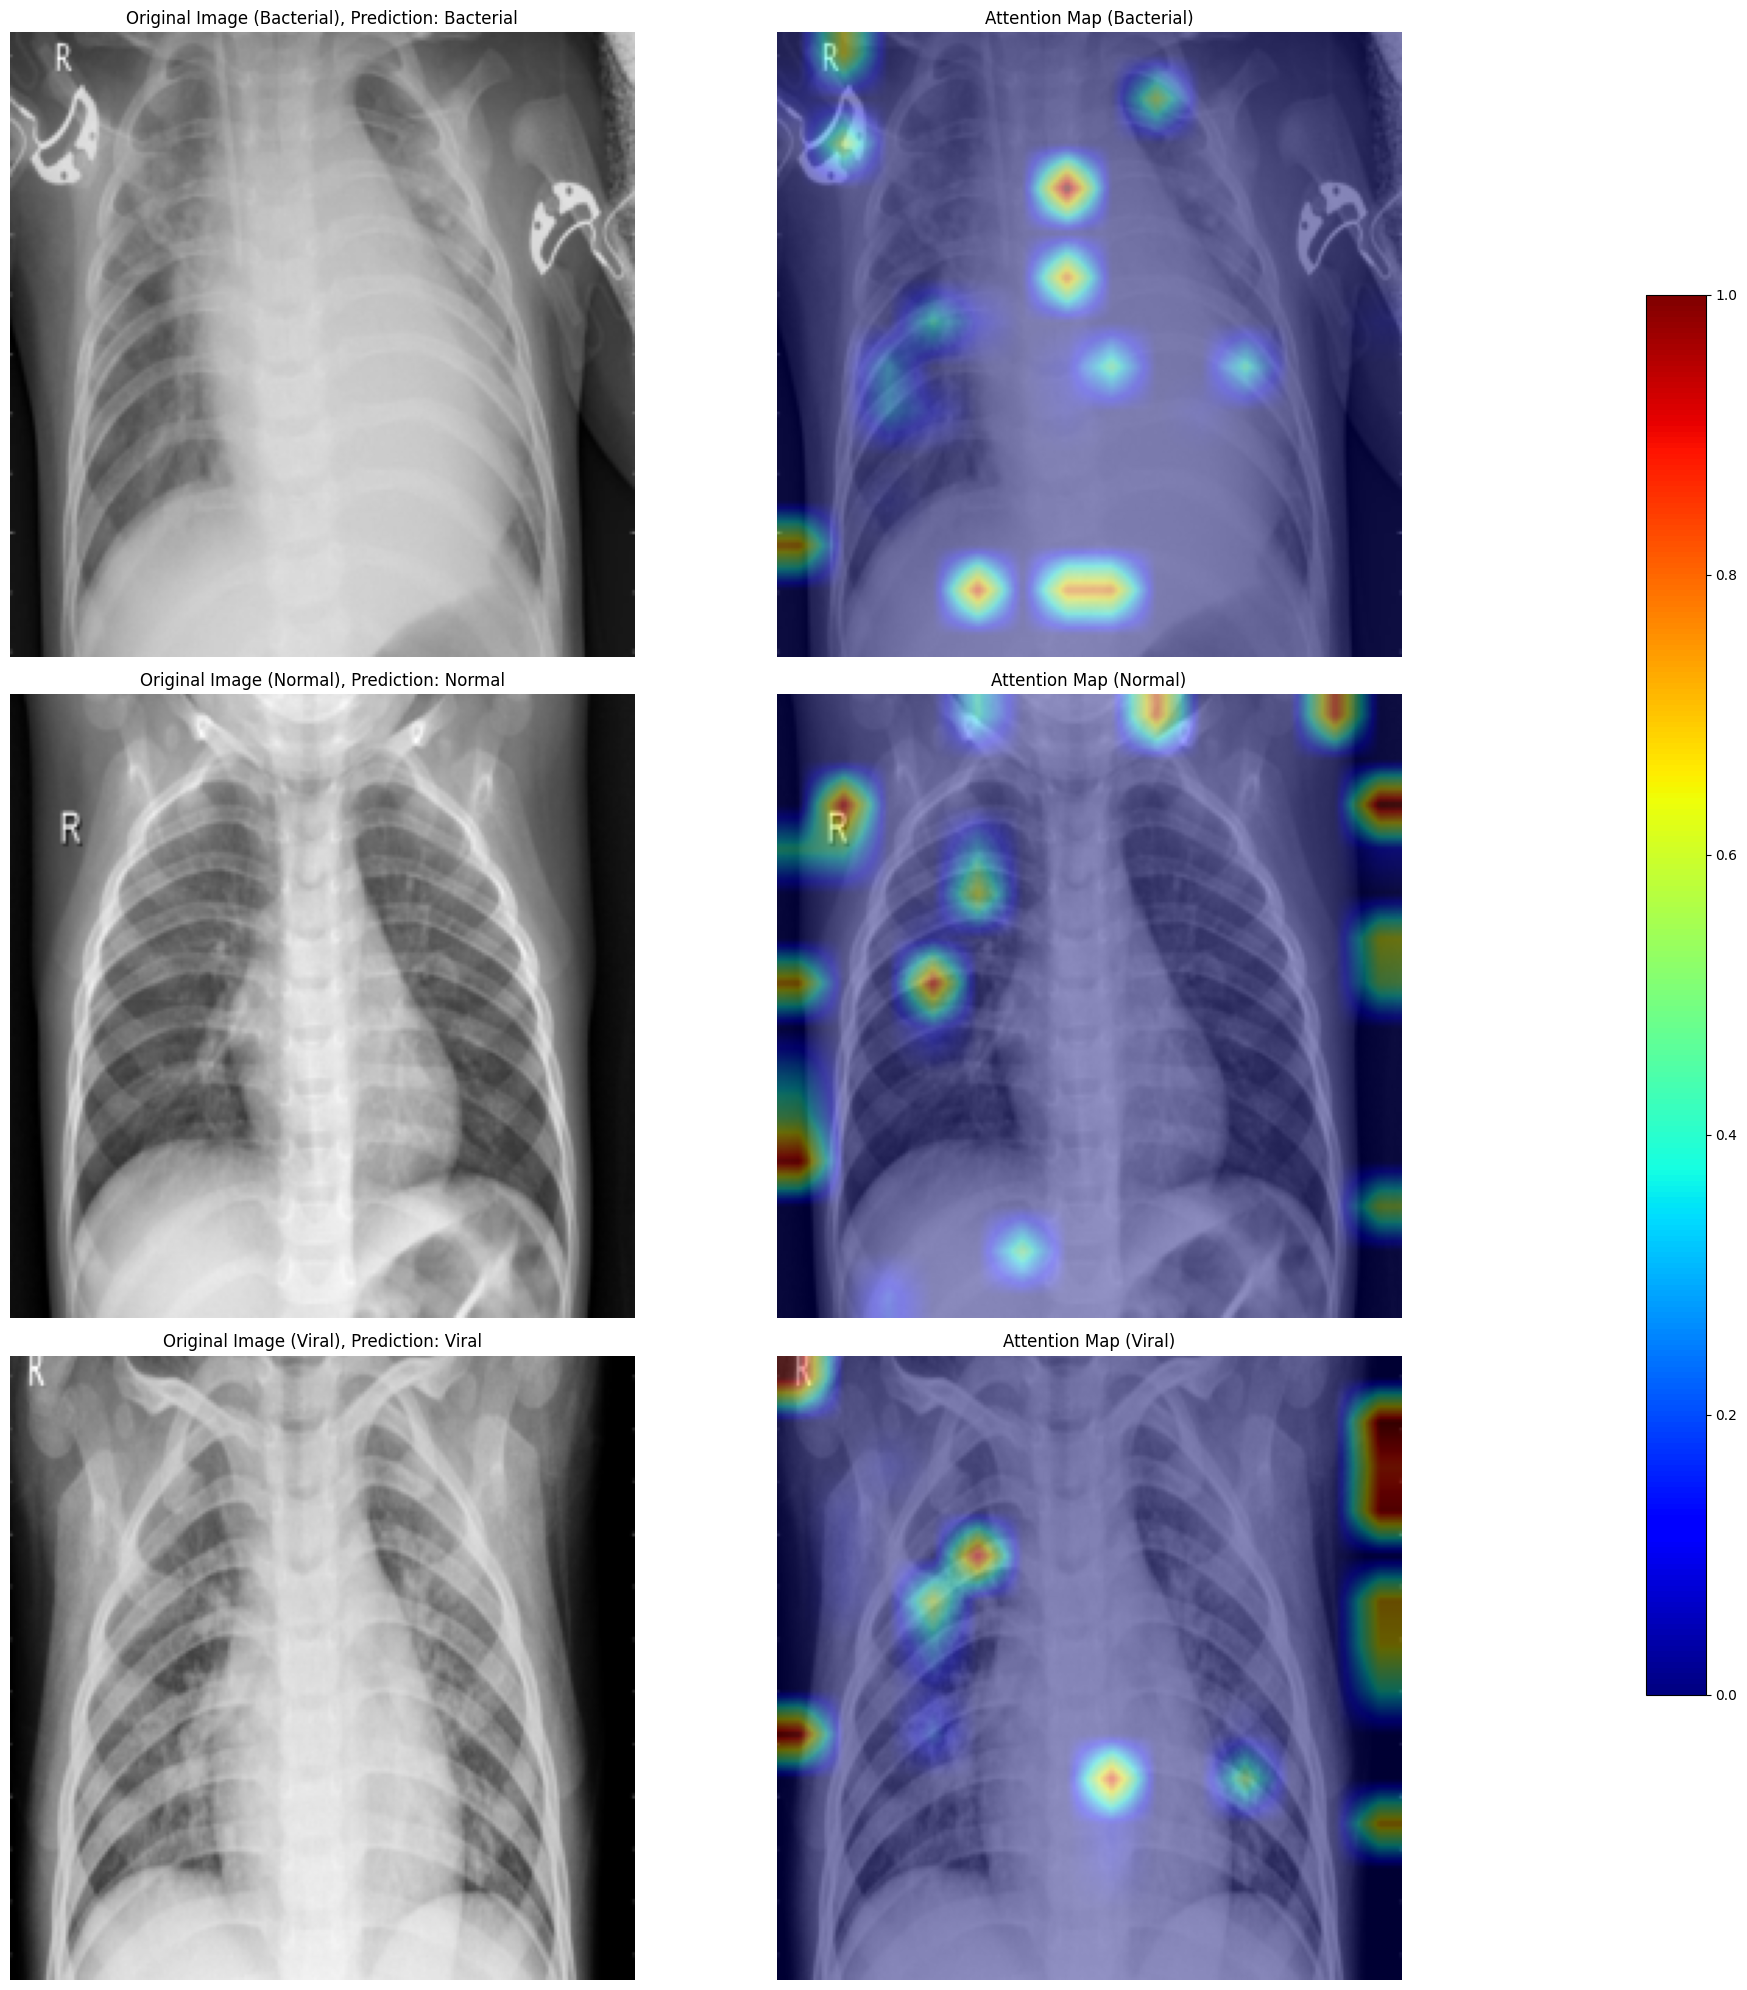

In [78]:

def show_final_layer_attention_maps(model, test_dataset, device, discard_ratio=0.9, head_fusion="mean"):
    # Put the model in evaluation mode
    model.eval()

    # Move the model to the specified device
    model.to(device)

    # Create a DataLoader with batch size equal to the number of images
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

    class_names = test_dataset.features['label'].names

    samples = [None] * 3  # Initialize list to store samples for each class

    for batch in test_loader:
        images, labels = batch['pixel_values'].to(device), batch['labels'].to(device)

        for image, label in zip(images, labels):
            # Check if a sample for the current class has already been found
            if samples[label] is None:
                samples[label] = image

        # Check if samples for all classes have been found
        if all(sample is not None for sample in samples):
            break
    
    print("Samples found for all classes!")

    # Create a figure to plot the attention maps
    fig, axs = plt.subplots(3, 2, figsize=(20, 20))

    # Iterate over the samples
    with torch.no_grad():
        for i, image in enumerate(samples):
            
            label = class_names[i]

            # Forward pass through the model
            outputs = model(image.unsqueeze(0), output_attentions=True)

            prediciton = torch.argmax(outputs.logits, dim=-1).item()

            predicted_class = class_names[prediciton]

            #scale image to [0, 1]
            image = image - image.min()
            image = image / image.max()

            # Plot the original image

            axs[i, 0].imshow(image.permute(1, 2, 0).cpu())
            axs[i, 0].axis('off')
            axs[i, 0].set_title(f"Original Image ({label}), Prediction: {predicted_class}")

            # Initialize the result tensor and recursively fuse the attention maps
            result = torch.eye(outputs.attentions[0].size(-1)).to(device)

            


            last_attention_heads = outputs.attentions[-1].unsqueeze(0)


            for attention in last_attention_heads:
                if head_fusion == "mean":
                    attention_heads_fused = attention.mean(axis=1)
                elif head_fusion == "max":
                    attention_heads_fused = attention.max(axis=1)[0]
                elif head_fusion == "min":
                    attention_heads_fused = attention.min(axis=1)[0]

                flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)

                _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
                indices = indices[indices != 0]
                flat[0, indices] = 0

                I = torch.eye(attention_heads_fused.size(-1)).to(device)
                a = (attention_heads_fused + 1.0*I)/2
                a = a / a.sum(dim=-1)

                result = torch.matmul(a, result)

            mask = result[0, 0, 1:]
            # In case of 224x224 image, this brings us from 196 to 14
            width = int(mask.size(-1)**0.5)
            mask = mask.reshape(width, width).cpu().numpy()
            mask = mask / np.max(mask)

            mask = cv2.resize(mask, (224, 224))

            # Normalize mask to [0, 1] for visualization
            mask = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))
            heatmap = plt.cm.jet(mask)[:, :, :3]  # Apply colormap

            # Superimpose heatmap on the original image
            showed_img = image.permute(1, 2, 0).cpu().numpy()
            showed_img = (showed_img - np.min(showed_img)) / (np.max(showed_img) - np.min(showed_img))  # Normalize image
            superimposed_img = heatmap * 0.4 + showed_img * 0.6  # Combine heatmap with original image

            # Plot attention map
            axs[i, 1].imshow(superimposed_img)
            axs[i, 1].axis('off')
            axs[i, 1].set_title(f"Attention Map ({label})")

        # Create colorbar as a separate axes
        cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Position of the colorbar
        norm = plt.Normalize(vmin=0, vmax=1)
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        fig.colorbar(sm, cax=cbar_ax)

        plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
        plt.show()

# Example usage:
show_final_layer_attention_maps(best_model, prepared_dataset_test_vision_transformer, device, discard_ratio=0.9, head_fusion="max")
